In [193]:
from tranction_reduction import TranctionReduction
import pandas as pd
import numpy as np
import numpy_indexed as npi
from itertools import combinations, product
from functools import reduce
from collections.abc import Iterable
import math
import timeit
# use for vertify
import matplotlib.pyplot as plt
import apriori


In [194]:
real_dataset_path = "/home/sokhorn/sokhorn/dataSet/data/Online Retail.csv"
# testing_dataset_path = '/home/sokhorn/sokhorn/dataSet/data/sample_data_set.csv'
tranction_reduction_itemsets = '/home/sokhorn/sokhorn/dataSet/data/sample_tranc_red.csv'
sample_dataset = pd.read_csv(
    tranction_reduction_itemsets, sep=',', usecols=[
        'InvoiceNo',
        'StockCode',
        'Quantity'
    ])
sample_dataset
item_sets = (
    sample_dataset.groupby(['InvoiceNo', 'StockCode', ])['Quantity']
    .sum().unstack().reset_index().fillna(0)
    .set_index("InvoiceNo")
)
item_sets = item_sets.iloc[:, :150]
item_sets = item_sets.head(958)
item_sets = item_sets.applymap(lambda x: 1 if x > 0 else 0)
item_sets.reindex(sorted(item_sets.columns), axis=1)
item_sets


StockCode,I1,I2,I3,I4,I5
InvoiceNo,,,,,
1,1,1,0,0,1
2,0,1,0,1,0
3,0,1,1,0,0
4,1,1,0,1,0
5,1,0,1,0,0
6,0,1,1,0,0
7,1,0,1,0,0
8,1,1,1,0,1
9,1,1,1,0,0


In [195]:
item_sets


StockCode,I1,I2,I3,I4,I5
InvoiceNo,,,,,
1,1,1,0,0,1
2,0,1,0,1,0
3,0,1,1,0,0
4,1,1,0,1,0
5,1,0,1,0,0
6,0,1,1,0,0
7,1,0,1,0,0
8,1,1,1,0,1
9,1,1,1,0,0


In [196]:
tranc_reduction = TranctionReduction(item_sets)


In [197]:
df_rc, rc = tranc_reduction.df_rc(item_sets)
df_rc


,I1,I2,I3,I4,I5
0,1,1,0,0,1
1,0,1,0,1,0
2,0,1,1,0,0
3,1,1,0,1,0
4,1,0,1,0,0
5,1,1,1,0,1
6,1,1,1,0,0


### Computing theminimum0-support for mining frequent patterns


In [198]:
item_sets


StockCode,I1,I2,I3,I4,I5
InvoiceNo,,,,,
1,1,1,0,0,1
2,0,1,0,1,0
3,0,1,1,0,0
4,1,1,0,1,0
5,1,0,1,0,0
6,0,1,1,0,0
7,1,0,1,0,0
8,1,1,1,0,1
9,1,1,1,0,0


In [199]:
tranc_reduction_apri = TranctionReduction(item_sets)
tranc_reduction_apri.df_rc(item_sets)


(   I1  I2  I3  I4  I5
 0   1   1   0   0   1
 1   0   1   0   1   0
 2   0   1   1   0   0
 3   1   1   0   1   0
 4   1   0   1   0   0
 5   1   1   1   0   1
 6   1   1   1   0   0,
 0    1
 1    1
 2    2
 3    1
 4    2
 5    1
 6    1
 Name: RC, dtype: int64)

In [200]:
import imp
from telnetlib import RCP
from typing_extensions import Self
import numpy as np
import typing
import itertools
import numpy_indexed as npi
import pandas as pd
from functools import reduce

from soupsieve import select


class TranctionReduction1:

    def __init__(self, itemsets):
        # RC count generation
        self. itemset_reduct, self.rc_values = npi.count(itemsets.values)

    # Support Count
    # reduce(function, input)
    def support_k_itemst(self, k_itemst):
        s = 0
        for i in range(len(k_itemst)):
            s += reduce(lambda a, b: a & b, k_itemst[i] & self.RC[i])
        return s

    def support_appriori(self, k_itemset, item_sets):
        # get all row which value are equal to 1
        mask = (k_itemset == 1).all(axis=1)
        return len(item_sets[mask]) / len(item_sets)

    def get_frequent_tranc_apiori(self, ck, min_support, prev_discard, item_sets):
        L = []
        support_count = []
        new_discard = []
        k = len(prev_discard)
        for i in range(len(ck)):
            discard_before = False
            result = ck[i]

            # if result in prev_discard than break this loop
            if k > 0:
                for it in prev_discard[k]:
                    if set(it).issubset(set(result)):
                        discard_before = True
                        break

            if not discard_before:
                # print(f'item {mergeKItemIntoOne(item)}')
                # print(f"Ck-reuslt {ck}, result {result}")
                count = self.support_appriori(item_sets[result], item_sets)

                if count >= min_support:

                    L.append(result)
                    support_count.append(count)
                else:
                    new_discard.append(result)
        return L, support_count, new_discard

    def frequent_item_set_gen_apiori(self, item_sets, minimum_support):
        C = {}
        L = {}
        Discard = {}
        support_count = {}
        itemset_size = 1
        Discard.update({itemset_size: []})

        # remove each column who support count are less than min_support for 1 itemsets
        # ---------------------------
        rc_1_itemset = item_sets.sum(axis=0)
        # remove all column which sum of row are ness than user defind support threshold
        cut_our_cols = rc_1_itemset.loc[lambda x: x < minimum_support].index
        # cut our every itemset which are sum of each row are less than user defind support
        item_sets.drop(labels=cut_our_cols, axis=1, inplace=True)
        # updpate the first item set which are in frequent
        Discard.update({itemset_size: cut_our_cols})

        # Frequent 1 itemsets
        C.update({itemset_size: np.reshape(list(item_sets.columns), (-1, 1))})

        f, supp, new_discard = self.get_frequent_tranc_apiori(
            C[itemset_size], minimum_support, Discard, item_sets)

        Discard.update({itemset_size: new_discard})
        L.update({itemset_size: f})
        support_count.update({itemset_size: supp})

        k = itemset_size + 1
        while True:
            try:
                C.update(
                    {
                        k: list(join_step(L[k - 1]))
                    }
                )
                f, supp, new_discard = self.get_frequent_tranc_apiori(
                    C[k], minimum_support, Discard, item_sets)
                L.update({k: f})
                if(len(L[k]) == 0):
                    C.pop(k)
                    break
                else:
                    Discard.update({k: new_discard})
                    support_count.update({k: supp})
                    k += 1
            except ValueError as err:
                print(f"Hello, there some error with {err}")
                break

        return C, support_count, Discard


def join_step(itemsets: typing.List[tuple]):
    i = 0

    while i < len(itemsets):

        skip = 1

        * itemset_first, itemset_last = itemsets[i]

        tail_items = [itemset_last]
        tail_items_append = tail_items.append

        for j in range(i + 1, len(itemsets)):

            *itemset_n_first, itemset_n_last = itemsets[j]

            if itemset_first == itemset_n_first:  # k - 1, item are identical
                tail_items_append(itemset_n_last)
                skip += 1
            else:
                break

        itemset_first_tuple = tuple(itemset_first)
        for a, b in sorted(itertools.combinations(tail_items, 2)):
            yield list(itemset_first_tuple + (a,) + (b,))

        i += skip


In [201]:
tranc_reduction_apri = TranctionReduction1(item_sets)
fi, s, d = tranc_reduction_apri.frequent_item_set_gen_apiori(
    item_sets, minimum_support=0.6
)


In [202]:
item_column = item_sets.columns


In [203]:
def all_itemset(item_column):
    for i in range(1, len(item_column)):
        oc = combinations(item_column, i)
        for c in oc:
            yield tranc_reduction_apri.support_appriori(item_sets[list(c)], item_sets)
            if(len(c) >= 3):
                break


def a_b_avg(supports):
    return min(supports), max(supports), sum(supports) / len(supports)


In [204]:
a_b_avg(list(all_itemset(item_column)))


(0.0, 0.7777777777777778, 0.29411764705882354)

In [205]:
def lean(support_count_i_itemset, M, avg):
    less_than_avg = []
    greater_than_avg = []
    for j in support_count_i_itemset:
        if j < avg:
            less_than_avg.append(1)
        elif j > avg:
            greater_than_avg.append(1)
    # print(f"Less avg {less_than_avg}")
    # print(f"Greater avg {greater_than_avg}")
    return (sum(less_than_avg) - sum(greater_than_avg)) / M


In [206]:
def a_avgsupp(m, k, N):
    n_over_N = sum([math.pow(m / N, i) for i in range(k, m)])
    operation = 1 / (m - k + 1)
    return n_over_N * operation


a_avgsupp(5, 2, 1000)


6.28140625e-06

In [207]:
def actul_minimum_support(a, b, r_min, n=1):
    return ((pow(b, n) - pow(a, n)) * r_min + pow(a, n))


In [208]:
actul_minimum_support(0.25, 0.75, 0.7)


0.6

In [209]:
actul_minimum_support(0.25, 0.75, 0.7, n=3)


0.3

In [210]:
ac_mini = actul_minimum_support(a=0.25, b=0.75, r_min=0.7, n=3)
ac_mini


0.3

In [211]:
item_sets


StockCode,I1,I2,I3,I4,I5
InvoiceNo,,,,,
1,1,1,0,0,1
2,0,1,0,1,0
3,0,1,1,0,0
4,1,1,0,1,0
5,1,0,1,0,0
6,0,1,1,0,0
7,1,0,1,0,0
8,1,1,1,0,1
9,1,1,1,0,0


In [212]:
fi, s, d = tranc_reduction_apri.frequent_item_set_gen_apiori(
    item_sets, minimum_support=ac_mini
)
fi


{1: array([['I1'],
        ['I2'],
        ['I3'],
        ['I4'],
        ['I5']], dtype='<U2'),
 2: [['I1', 'I2'], ['I1', 'I3'], ['I2', 'I3']]}

In [213]:
item_sets


StockCode,I1,I2,I3,I4,I5
InvoiceNo,,,,,
1,1,1,0,0,1
2,0,1,0,1,0
3,0,1,1,0,0
4,1,1,0,1,0
5,1,0,1,0,0
6,0,1,1,0,0
7,1,0,1,0,0
8,1,1,1,0,1
9,1,1,1,0,0


In [214]:
# Sebastian Raschka 2014-2020
# myxtend Machine Learning Library Extensions
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

import numpy as np
import pandas as pd
import fpcommon as fpc


def generate_new_combinations(old_combinations):
    """
    Generator of all combinations based on the last state of Apriori algorithm
    Parameters
    -----------
    old_combinations: np.array
        All combinations with enough support in the last step
        Combinations are represented by a matrix.
        Number of columns is equal to the combination size
        of the previous step.
        Each row represents one combination
        and contains item type ids in the ascending order
        ```
               0        1
        0      15       20
        1      15       22
        2      17       19
        ```

    Returns
    -----------
    Generator of all combinations from the last step x items
    from the previous step.

    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori

    """
    # items_types_in_previous_step = np.unique(old_combinations.flatten())
    # for old_combination in old_combinations:
    #     max_combination = old_combination[-1]  # get a single item in the last
    #     mask = items_types_in_previous_step > max_combination
    #     valid_items = items_types_in_previous_step[mask]
    #     old_tuple = tuple(old_combination)
    #     for item in valid_items:
    #         yield from old_tuple
    #         yield item

    items_types_in_previous_step = np.unique(old_combinations.flatten())
    for old_combination in old_combinations:
        max_combination = old_combination[-1]  # get a single item in the last
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]
        old_tuple = tuple(old_combination)
        for item in valid_items:

            yield from old_tuple
            yield item


def generate_new_combinations_low_memory(old_combinations, X, min_support,
                                         is_sparse):

    items_types_in_previous_step = np.unique(old_combinations.flatten())
    rows_count = X.shape[0]
    threshold = min_support * rows_count
    for old_combination in old_combinations:
        max_combination = old_combination[-1]
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]
        old_tuple = tuple(old_combination)
        if is_sparse:
            mask_rows = X[:, old_tuple].toarray().all(axis=1)
            X_cols = X[:, valid_items].toarray()
            supports = X_cols[mask_rows].sum(axis=0)
        else:
            mask_rows = X[:, old_tuple].all(axis=1)
            supports = X[mask_rows][:, valid_items].sum(axis=0)
        valid_indices = (supports >= threshold).nonzero()[0]
        for index in valid_indices:
            yield supports[index]
            yield from old_tuple
            yield valid_items[index]


def apriori(df, min_support=0.5, use_colnames=False, max_len=None, verbose=0,
            low_memory=False):
  

    def _support(_x, _n_rows, _is_sparse):
     
        out = (np.sum(_x, axis=0) / _n_rows)
        return np.array(out).reshape(-1)

    if min_support <= 0.:
        raise ValueError('`min_support` must be a positive '
                         'number within the interval `(0, 1]`. '
                         'Got %s.' % min_support)

    fpc.valid_input_check(df)

    if hasattr(df, "sparse"):
        # DataFrame with SparseArray (pandas >= 0.24)
        if df.size == 0:
            X = df.values
        else:
            X = df.sparse.to_coo().tocsc()
        is_sparse = True
    else:
        # dense DataFrame
        X = df.values
        is_sparse = False
    support = _support(X, X.shape[0], is_sparse)
    ary_col_idx = np.arange(X.shape[1])
    support_dict = {1: support[support >= min_support]}
    itemset_dict = {1: ary_col_idx[support >= min_support].reshape(-1, 1)}
    max_itemset = 1
    rows_count = float(X.shape[0])

    all_ones = np.ones((int(rows_count), 1))

    while max_itemset and max_itemset < (max_len or float('inf')):
        next_max_itemset = max_itemset + 1

        # With exceptionally large datasets, the matrix operations can use a
        # substantial amount of memory. For low memory applications or large
        # datasets, set `low_memory=True` to use a slower but more memory-
        # efficient implementation.
        if low_memory:
            combin = generate_new_combinations_low_memory(
                itemset_dict[max_itemset], X, min_support, is_sparse)
            # slightly faster than creating an array from a list of tuples
            combin = np.fromiter(combin, dtype=int)
            combin = combin.reshape(-1, next_max_itemset + 1)

            if combin.size == 0:
                break
            if verbose:
                print(
                    '\rProcessing %d combinations | Sampling itemset size %d' %
                    (combin.size, next_max_itemset), end="")

            itemset_dict[next_max_itemset] = combin[:, 1:]
            support_dict[next_max_itemset] = combin[:, 0].astype(float) \
                / rows_count
            max_itemset = next_max_itemset
        else:
            # conver from generator to numpy
            combin = generate_new_combinations(itemset_dict[max_itemset])
            combin = np.fromiter(combin, dtype=int)
            combin = combin.reshape(-1, next_max_itemset)

            # end generator
            if combin.size == 0:
                break
            if verbose:
                print(
                    '\rProcessing %d combinations | Sampling itemset size %d' %
                    (combin.size, next_max_itemset), end="")

            if is_sparse:
                _bools = X[:, combin[:, 0]] == all_ones
                for n in range(1, combin.shape[1]):
                    _bools = _bools & (X[:, combin[:, n]] == all_ones)
            else:
                _bools = np.all(X[:, combin], axis=2)

            support = _support(np.array(_bools), rows_count, is_sparse)

            _mask = (support >= min_support).reshape(-1)

            if any(_mask):

                itemset_dict[next_max_itemset] = np.array(combin[_mask])
                support_dict[next_max_itemset] = np.array(support[_mask])
                max_itemset = next_max_itemset

            else:
                # Exit condition
                # when there no more itemst
                break

    all_res = []
    for k in sorted(itemset_dict):
        support = pd.Series(support_dict[k])
        itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]],
                             dtype='object')

        res = pd.concat((support, itemsets), axis=1)
        all_res.append(res)

    res_df = pd.concat(all_res)
    res_df.columns = ['support', 'itemsets']
    if use_colnames:
        mapping = {idx: item for idx, item in enumerate(df.columns)}
        res_df['itemsets'] = res_df['itemsets'].apply(lambda x: frozenset([
                                                      mapping[i] for i in x]))
    res_df = res_df.reset_index(drop=True)

    if verbose:
        print()  # adds newline if verbose counter was used

    return res_df



In [215]:
# def def_use_col(itemset_dict, support_dict, df):
#     all_res = []
#     for k in sorted(itemset_dict):
#         support = pd.Series(support_dict[k])
#         itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]],
#                              dtype='object')
#         res = pd.concat((support, itemsets), axis=1)
#         all_res.append(res)

#     res_df = pd.concat(all_res)
#     res_df.columns = ['support', 'itemsets']

#     mapping = {idx: item for idx, item in enumerate(df.columns)}
#     res_df['itemsets'] = res_df['itemsets'].apply(lambda x: frozenset([
#         mapping[i] for i in x]))
#     print(f"res_df : {res_df}")


In [216]:
# def support(_x, _n_rows):
#     out = (np.sum(_x, axis=0) / _n_rows)
#     return np.array(out).reshape(-1)


### Tranction Reduction


In [217]:
# RC count generation
itemset_reduct, rc_values = npi.count(item_sets.values)


In [218]:
itemset_reduct = pd.DataFrame(itemset_reduct, columns=item_sets.columns)
itemset_reduct


StockCode,I1,I2,I3,I4,I5
0,0,1,0,1,0
1,0,1,1,0,0
2,1,0,1,0,0
3,1,1,0,0,1
4,1,1,0,1,0
5,1,1,1,0,0
6,1,1,1,0,1


In [219]:
# Sebastian Raschka 2014-2020
# myxtend Machine Learning Library Extensions
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

import numpy as np
import pandas as pd
import fpcommon as fpc


def generate_new_combinations(old_combinations):

    items_types_in_previous_step = np.unique(old_combinations.flatten())
    for old_combination in old_combinations:
        max_combination = old_combination[-1]  # get a single item in the last
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]

        old_tuple = tuple(old_combination)
        for item in valid_items:
            yield from old_tuple
            yield item


def generate_new_combinations_low_memory(old_combinations, X, min_support,
                                         is_sparse):

    items_types_in_previous_step = np.unique(old_combinations.flatten())
    rows_count = X.shape[0]
    threshold = min_support * rows_count
    for old_combination in old_combinations:
        max_combination = old_combination[-1]
        mask = items_types_in_previous_step > max_combination
        valid_items = items_types_in_previous_step[mask]
        old_tuple = tuple(old_combination)
        if is_sparse:
            mask_rows = X[:, old_tuple].toarray().all(axis=1)
            X_cols = X[:, valid_items].toarray()
            supports = X_cols[mask_rows].sum(axis=0)
        else:
            mask_rows = X[:, old_tuple].all(axis=1)
            supports = X[mask_rows][:, valid_items].sum(axis=0)
        valid_indices = (supports >= threshold).nonzero()[0]
        for index in valid_indices:
            yield supports[index]
            yield from old_tuple
            yield valid_items[index]


def apriori1(df, min_support=0.5, use_colnames=False, max_len=None, verbose=0):

    def _bitwise_every_row(a):
        return reduce(lambda k_itmeset, rc: k_itmeset & rc, a[:-1], a[-1])

    def fre_1_itemset(itemset_reduct):
        # Remove every 1 itemset which are less than minimum support
        rc_1_itemset = itemset_reduct.sum(axis=0)
        # remove all column which sum of row are ness than user defind support threshold
        cut_our_cols = rc_1_itemset.loc[lambda x: x < min_support].index
        # cut our every itemset which are sum of each row are less than user defind support
        itemset_reduct.drop(labels=cut_our_cols, axis=1, inplace=True)
        item_index = np.arange(itemset_reduct.shape[1])
        # print(
        #     f"item_index : {item_index}\n, frequent 1 itemset : {rc_1_itemset.values}")
        return rc_1_itemset.values,  item_index

    if min_support <= 0.:
        raise ValueError('`min_support` must be a positive '
                         'number within the interval `(0, 1]`. '
                         'Got %s.' % min_support)

    fpc.valid_input_check(df)

    if hasattr(df, "sparse"):
        # DataFrame with SparseArray (pandas >= 0.24)
        if df.size == 0:
            X = df.values
        else:
            X = df.sparse.to_coo().tocsc()
    else:
        # dense DataFrame
        X = df.values

    fre_1_itemset, fre_1_support = fre_1_itemset(df)

    support_dict = {1: fre_1_itemset}
    itemset_dict = {1: fre_1_support.reshape(-1, 1)}
    max_itemset = 1

    print('-------------')
    print(fre_1_itemset, end='\n\n')
    print(fre_1_support, end='\n\n')
    print('-------------')

    while max_itemset and max_itemset < (max_len or float('inf')):

        next_max_itemset = max_itemset + 1
        # convert from generator to numpy
        combin = generate_new_combinations(itemset_dict[max_itemset])
        combin = np.fromiter(combin, dtype=int)
        combin = combin.reshape(-1, next_max_itemset)

        if combin.size == 0:  # No more itemset to generate
            break

        rc = np.repeat(rc_values, X[:, combin].shape[1], axis=0).reshape(
            rc_values.shape[0], X[:, combin].shape[1], 1)
        X1_combine1 = np.dstack((X[:, combin], rc))

        bit_result = np.apply_along_axis(
            _bitwise_every_row, axis=2, arr=X1_combine1)

        support = bit_result.sum(axis=0)

        print('-------------')
        print(combin, end='\n\n')
        print(bit_result, end='\n\n')
        print(support, end='\n\n')

        print('-------------')
        _mask = (support >= min_support).reshape(-1)

        if any(_mask):
            # this will be generate item those are frequent
            itemset_dict[next_max_itemset] = np.array(combin[_mask])
            support_dict[next_max_itemset] = np.array(support[_mask])
            max_itemset = next_max_itemset
        else:
            # Exit condition
            # when there no more itemst
            break

    all_res = []
    for k in sorted(itemset_dict):
        support = pd.Series(support_dict[k])
        itemsets = pd.Series([frozenset(i) for i in itemset_dict[k]],
                             dtype='object')
        res = pd.concat((support, itemsets), axis=1)
        all_res.append(res)

    res_df = pd.concat(all_res)
    print(all_res)
    res_df.columns = ['support', 'itemsets']
    if use_colnames:
        mapping = {idx: item for idx, item in enumerate(df.columns)}
        try:
            res_df['itemsets'] = res_df['itemsets'].apply(
                lambda x: frozenset([mapping[i] for i in x])
            )
        except:
            print("Error error tv.")

    res_df = res_df.reset_index(drop=True)
    return res_df, itemset_dict

    


In [220]:
normal_support = np.linspace(0.1, 1, 10)
tranc_reduc_support = np.linspace(1, 10, 10, dtype=int)
print(normal_support)
print(tranc_reduc_support)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[ 1  2  3  4  5  6  7  8  9 10]


In [221]:
tranction_reduc_times = []
tranction_reduc_support_result = []
for support in tranc_reduc_support:
    start_time = timeit.default_timer()
    res_df, itemset_dict = apriori1(
        itemset_reduct, use_colnames=True, min_support=support)
    end_time = timeit.default_timer()
    tranction_reduc_times.append(end_time - start_time)
    tranction_reduc_support_result.append(support)



-------------
[5 6 4 2 2]

[0 1 2 3 4]

-------------
-------------
[[0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 2]
 [1 3]
 [1 4]
 [2 3]
 [2 4]
 [3 4]]

[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 1 0 0 0]
 [1 0 1 0 0 1 0 0 0 0]
 [1 1 0 0 1 0 0 0 0 0]
 [1 1 0 1 1 0 1 0 1 0]]

[4 2 1 2 2 2 2 0 1 0]

-------------
-------------
[[0 1 2]
 [0 1 3]
 [0 1 4]
 [0 2 3]
 [0 2 4]
 [0 3 4]
 [1 2 3]
 [1 2 4]
 [1 3 4]]

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 1 0]]

[2 1 2 0 1 0 0 1 0]

-------------
-------------
[[0 1 2 3]
 [0 1 2 4]
 [0 1 3 4]]

[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 1 0]]

[0 1 0]

-------------
[   0    1
0  5  (0)
1  6  (1)
2  4  (2)
3  2  (3)
4  2  (4),    0       1
0  4  (0, 1)
1  2  (0, 2)
2  1  (0, 3)
3  2  (0, 4)
4  2  (1, 2)
5  2  (1, 3)
6  2  (1, 4)
7  1  (2, 4),    0          1
0  2  (0, 1, 2)
1  1  (0, 1, 3)
2  2  (0, 1, 4

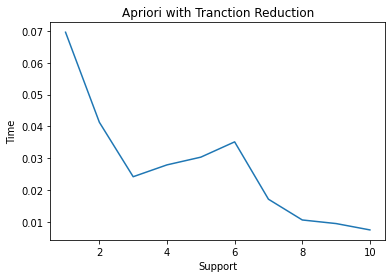

In [222]:
plt.xlabel("Support")
plt.ylabel("Time")
plt.title("Apriori with Tranction Reduction")
plt.plot( tranc_reduc_support, tranction_reduc_times)

Text(0.5, 1.0, 'Apriori')

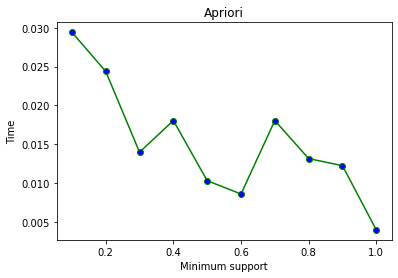

In [223]:
result_supports = []
result_times = []
for i in normal_support:
    stat_time = timeit.default_timer()
    apriori(item_sets, use_colnames=True, min_support=i)
    stop = timeit.default_timer()
    result_times.append(stop - stat_time)
    result_supports.append(i)


# plotting the points
plt.plot(result_supports, result_times, color='green',
         marker='o', markerfacecolor='blue', markersize=6)


# naming the x axis
plt.xlabel('Minimum support')
# naming the y axis
plt.ylabel('Time')

# giving a title to my graph
plt.title('Apriori')

# function to show the plot
# plt.show()


In [224]:
start_time = timeit.default_timer()
apriori(item_sets, use_colnames=True, min_support=1)
print(timeit.default_timer() - start_time)


0.007552761999704671


In [227]:
result_supports

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

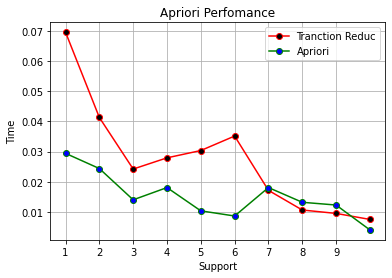

In [254]:
plt.title("Apriori Perfomance")
plt.ylabel("Time")
plt.xlabel("Support")
plt.xticks(np.arange(0, 10))
plt.plot(tranc_reduc_support, tranction_reduc_times,
         label='Tranction Reduc', marker='o', color='red', markerfacecolor='black')
plt.plot(normal_support * 10, result_times, color='green',
         marker='o', markerfacecolor='blue', markersize=6, label='Apriori')
plt.grid()
plt.legend(loc='best')
